# Universidad de Buenos Aires
# Deep Learning - TP1
# Julio 2024

### Autor: Julio Agustín Donadello
### Fecha de entrega: 28-07-2024

El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el Domingo 28 de Julio inclusive. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: alfonsorafel93@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y
visualizables en el colab. El colab debe poder ser ejecutado sin errores y las celdas no deben contener codigo que no corresponda con la ejecucion de las mismas.



---
# 1. Análisis de datos

Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.

In [29]:
# Importo librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
df = pd.read_csv("../content/drive/MyDrive/Colab Notebooks/ratings.csv")

In [32]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [33]:
# top movies
movie_vote_counts = df['movieId'].value_counts()
top_200_movies = movie_vote_counts.head(200).index
df_top_movies = df[df['movieId'].isin(top_200_movies)]

# top users
user_vote_counts = df_top_movies['userId'].value_counts()
users_with_100_votes = user_vote_counts[user_vote_counts >= 100].index
df_filtered = df_top_movies[df_top_movies['userId'].isin(users_with_100_votes)]

### Prescencia de nulos

In [34]:
df_filtered.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

### Tipos de dato

In [35]:
df_filtered.info() # se nota un target que toma valores continuos

<class 'pandas.core.frame.DataFrame'>
Index: 8329 entries, 1772 to 100452
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     8329 non-null   int64  
 1   movieId    8329 non-null   int64  
 2   rating     8329 non-null   float64
 3   timestamp  8329 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 325.4 KB


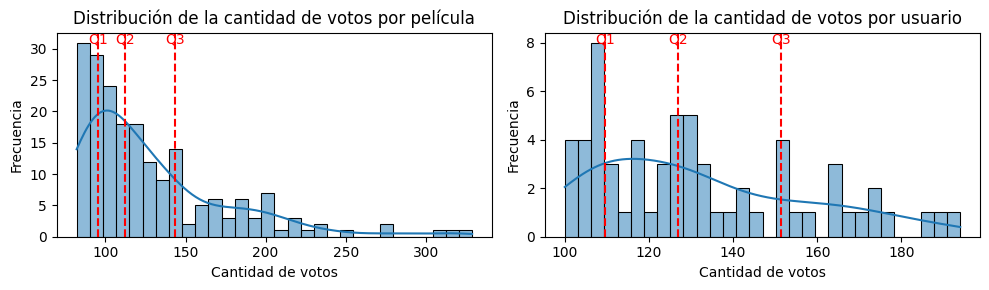

In [36]:
# cuartiles para movieId y userId
movie_quartiles = movie_vote_counts.head(200).quantile([0.25, 0.5, 0.75])
user_quartiles = user_vote_counts[user_vote_counts >= 100].quantile([0.25, 0.5, 0.75])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

sns.histplot(movie_vote_counts.head(200), bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribución de la cantidad de votos por película')
axes[0].set_xlabel('Cantidad de votos')
axes[0].set_ylabel('Frecuencia')
for i, q in enumerate(movie_quartiles, start=1):
    axes[0].axvline(q, color='r', linestyle='--')
    axes[0].text(q, max(axes[0].get_ylim())*0.95, f'Q{i}', color='r', ha='center')


sns.histplot(user_vote_counts[user_vote_counts >= 100], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribución de la cantidad de votos por usuario')
axes[1].set_xlabel('Cantidad de votos')
axes[1].set_ylabel('Frecuencia')
for i, q in enumerate(user_quartiles, start=1):
    axes[1].axvline(q, color='r', linestyle='--')
    axes[1].text(q, max(axes[1].get_ylim())*0.95, f'Q{i}', color='r', ha='center')


plt.tight_layout()
plt.show()

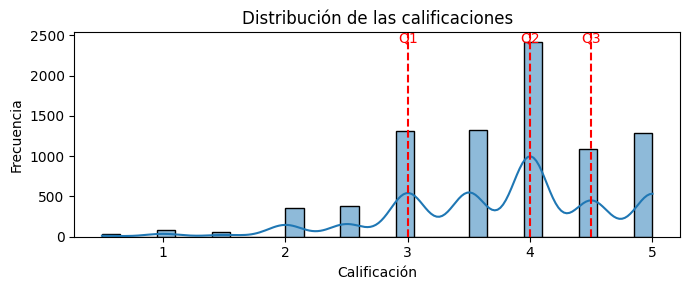

In [37]:
# Calcular los cuartiles para la columna 'rating'
rating_quartiles = df_filtered["rating"].quantile([0.25, 0.5, 0.75])

# Crear el gráfico de distribución de 'rating'
plt.figure(figsize=(7, 3))
sns.histplot(df_filtered["rating"], bins=30, kde=True)
plt.title('Distribución de las calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')

# Añadir líneas verticales y etiquetas para los cuartiles
for i, q in enumerate(rating_quartiles, start=1):
    plt.axvline(q, color='r', linestyle='--')
    plt.text(q, plt.ylim()[1]*0.95, f'Q{i}', color='r', ha='center')

plt.tight_layout()
plt.show()

Los ratings responden a saltos discretos de 0.5. Se denota una distibución sesgada a la derecha (valores de ratings más altos). La naturaleza de la predicción responde a una regresión pero los saltos discretos podrían ser abordados también como un problema de clasificación.

### Feature Engineering

Manipulación de la columna "timestamp" para generar información de potencial utilidad para el entrenamiento.

In [38]:
def cyclic_features(df, column, max_val):

    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    df.drop(columns=[column], inplace=True) # ya que es combinacion de ambos features

    return df

def f_eng(df, timestamp_col):
    # Convertir el timestamp a datetime
    df['datetime'] = pd.to_datetime(df[timestamp_col], unit='s')

    # Extraer características temporales
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['hour'] = df['datetime'].dt.hour

    # Características cíclicas
    df = cyclic_features(df, 'month', 12)
    df = cyclic_features(df, 'day_of_week', 7)
    df = cyclic_features(df, 'hour', 24)
    df = cyclic_features(df, 'day_of_year', 366)

    df.drop(columns=['datetime'], inplace=True)
    df.drop(columns=['timestamp'], inplace=True)

    return df

df_filtered = f_eng(df_filtered, 'timestamp')

In [39]:
df_filtered.head()

,userId,movieId,rating,year,month_sin,month_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos
1772,18,1,3.5,2016,0.866025,0.5,0.433884,-0.900969,-0.866025,-0.500000,0.660152,0.751132
1773,18,2,3.0,2016,0.866025,0.5,0.781831,0.623490,0.500000,-0.866025,0.722117,0.691771
1774,18,6,4.0,2016,0.866025,-0.5,-0.433884,-0.900969,-0.965926,-0.258819,0.991723,-0.128398
1775,18,16,4.5,2016,0.866025,-0.5,-0.433884,-0.900969,0.965926,-0.258819,0.932655,-0.360771
1776,18,32,4.0,2016,0.866025,0.5,0.433884,-0.900969,-0.866025,-0.500000,0.660152,0.751132


# 2. Embeddings
A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula. Usar tecnicas de normalizacion en caso de ser necesario.

In [170]:
df_final = df_filtered.drop(columns=['rating'])
x = df_final.to_numpy()
y = df_filtered["rating"].to_numpy()

In [171]:
# Normalizacion min-max
x_norm = x
x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0 ) - np.min(x, axis=0))

In [172]:
user_id = df_final['userId']
movie_id = df_final['movieId']

x_norm = x_norm[:, 2:] # elimino las columnas de userId y movieId para no sesgar al modelo

In [173]:
# Divido el dataset
idx = np.random.permutation(x_norm.shape[0])
train_idx = idx[0:int(0.85*len(idx))]
valid_idx = idx[int(0.85*len(idx)):]

train_x = x_norm[train_idx]
train_y = y[train_idx]
valid_x = x_norm[valid_idx]
valid_y = y[valid_idx]

n_train = train_x.shape[0]
n_valid = valid_x.shape[0]

## Construccion de Embeddings

In [174]:
user_id_to_idx = {value:i for i,value in enumerate(user_id.unique())}
movie_id_to_idx = {value:i for i,value in enumerate(movie_id.unique())}
print(f"#user: {len(user_id_to_idx)}  #movies: {len(movie_id_to_idx)}")

user_idx = np.array([user_id_to_idx[value] for value in user_id])
movie_idx = np.array([movie_id_to_idx[value] for value in movie_id])

#user: 63  #movies: 200


In [175]:
user_idx_train = user_idx[train_idx]
user_idx_valid = user_idx[valid_idx]

movie_idx_train = movie_idx[train_idx]
movie_idx_valid = movie_idx[valid_idx]

In [176]:
len(x), len(y), len(user_idx), len(movie_idx)

(8329, 8329, 8329, 8329)

## Construccion Red Neuronal

In [177]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [178]:
# Esta clase dataset sobreescribe los métodos init, len y getitem
class MyDatasetWithEmbddings(Dataset):

  def __init__(self, x, user_idx, movie_idx, y):
    self.x = x
    self.user_idx = user_idx
    self.movie_idx = movie_idx
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.user_idx[idx], self.movie_idx[idx], self.y[idx]

In [179]:
# Creo el dataset de entrenamiento y  validación
train_ds_embeddings = MyDatasetWithEmbddings(train_x, user_idx_train, movie_idx_train, train_y)
valid_ds_embeddings = MyDatasetWithEmbddings(valid_x, user_idx_valid, movie_idx_valid, valid_y)

In [180]:
train_dataloader_emb = DataLoader(train_ds_embeddings, batch_size =64, shuffle= True)
valid_dataloader_emb = DataLoader(valid_ds_embeddings, batch_size=64)

Para la construcción de la red, agrego capas de dropout ya que el modelo comienza a overfittear en todas las pruebas a partir de la época 20 aproximadamente.

In [181]:
# Arquitectura con embeddings
class NNetWithEmbeddings(torch.nn.Module):

  def __init__(self, emb_dim_us:int, emb_dim_mov:int):
    super().__init__()
    self.embeddings_users = torch.nn.Embedding(num_embeddings=63, embedding_dim=emb_dim_us)  # nota> #user: 63  #movies: 200
    self.embeddings_movies = torch.nn.Embedding(num_embeddings=200, embedding_dim=emb_dim_mov)
    self.linear_1 = torch.nn.Linear(in_features=9+emb_dim_us+emb_dim_mov, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(p=0.5)
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 100, out_features= 1, bias=True)

  def forward(self, x, user_idx, movie_idx):
    embeddings_user_outputs = self.embeddings_users(user_idx)
    embeddings_movie_outputs = self.embeddings_movies(movie_idx)
    x = torch.cat([x, embeddings_user_outputs, embeddings_movie_outputs], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.dropout(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.dropout(x)
    x = self.output(x)
    return x

## Entrenamiento

In [182]:
configs = {
    "lr": 0.001,
    "weight_decay": 0.005,
    "emb_dim_us": 5,
    "emb_dim_mov": 6,
    "epochs" : 90,
}

In [183]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cpu'

In [184]:
nnnetWithEmbeddings = NNetWithEmbeddings(configs["emb_dim_us"],configs["emb_dim_mov"])
nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)

In [185]:
loss_function = torch.nn.MSELoss(reduction='sum')
# Optimizador con regularización L2 (parámetro weight_decay)
optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=configs["lr"], weight_decay=configs["weight_decay"])

In [186]:
# Mini-Batch

# cantidad de epochs
epochs = configs["epochs"]

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

train_mse_by_epoch = []
valid_mse_by_epoch = []
train_mae_by_epoch = []
valid_mae_by_epoch = []
train_r2_by_epoch = []
valid_r2_by_epoch = []

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):

  ############################################
  ## Entrenamiento
  ############################################
  nnnetWithEmbeddings.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []

  for i,data in enumerate(train_dataloader_emb):
    # Obtengo los datos del batch de entrenamiento
    x_batch, embed_user_batch, embed_movie_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    embed_user_batch = embed_user_batch.to(device).int()
    embed_movie_batch = embed_movie_batch.to(device).int()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnnetWithEmbeddings(x_batch, embed_user_batch, embed_movie_batch)
    #y_batch_hat = 5*torch.sigmoid(nnet_output)
    #y_batch_hat = torch.clamp(nnet_output, min=0, max=5)
    y_batch_hat = nnet_output
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / len(train_dataloader_emb) #n_train
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  train_mse = metrics.mean_squared_error(epoch_y, epoch_y_hat)
  train_mse_by_epoch.append(train_mse)
  train_mae = metrics.mean_absolute_error(epoch_y, epoch_y_hat)
  train_mae_by_epoch.append(train_mae)
  train_r2 = metrics.r2_score(epoch_y, epoch_y_hat)
  train_r2_by_epoch.append(train_r2)

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnnetWithEmbeddings.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader_emb):
    # Obtengo los datos del batch de validación
    x_batch, embed_user_batch, embed_movie_batch, y_batch = data

    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    embed_user_batch = embed_user_batch.to(device).int()
    embed_movie_batch = embed_movie_batch.to(device).int()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    nnet_output = nnnetWithEmbeddings(x_batch, embed_user_batch, embed_movie_batch)
    #y_batch_hat = 5*torch.sigmoid(nnet_output)
    #y_batch_hat = torch.clamp(nnet_output, min=0, max=5)
    y_batch_hat = nnet_output

    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / len(train_dataloader_emb) #n_valid
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)

  # Cálculo la métrica de la epoch
  #valid_accuracy = metrics.accuracy_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])
  valid_mse = metrics.mean_squared_error(valid_epoch_y, valid_epoch_y_hat)
  valid_mse_by_epoch.append(valid_mse)
  valid_mae = metrics.mean_absolute_error(valid_epoch_y, valid_epoch_y_hat)
  valid_mae_by_epoch.append(valid_mae)
  valid_r2 = metrics.r2_score(valid_epoch_y, valid_epoch_y_hat)
  valid_r2_by_epoch.append(valid_r2)

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid MSE: {train_mse:.3f} / {valid_mse:.3f}")

 Epoch 0 | Train/Valid loss: 174.500 / 12.097 | Train/Valid MSE: 2.736 / 1.074
 Epoch 1 | Train/Valid loss: 91.596 / 11.023 | Train/Valid MSE: 1.436 / 0.979
 Epoch 2 | Train/Valid loss: 83.600 / 10.332 | Train/Valid MSE: 1.311 / 0.917
 Epoch 3 | Train/Valid loss: 79.794 / 9.465 | Train/Valid MSE: 1.251 / 0.840
 Epoch 4 | Train/Valid loss: 76.401 / 9.278 | Train/Valid MSE: 1.198 / 0.824
 Epoch 5 | Train/Valid loss: 72.275 / 9.100 | Train/Valid MSE: 1.133 / 0.808
 Epoch 6 | Train/Valid loss: 68.018 / 8.655 | Train/Valid MSE: 1.067 / 0.769
 Epoch 7 | Train/Valid loss: 66.518 / 8.372 | Train/Valid MSE: 1.043 / 0.743
 Epoch 8 | Train/Valid loss: 65.910 / 8.471 | Train/Valid MSE: 1.033 / 0.752
 Epoch 9 | Train/Valid loss: 64.901 / 8.097 | Train/Valid MSE: 1.018 / 0.719
 Epoch 10 | Train/Valid loss: 63.217 / 7.999 | Train/Valid MSE: 0.991 / 0.710
 Epoch 11 | Train/Valid loss: 63.954 / 7.835 | Train/Valid MSE: 1.003 / 0.696
 Epoch 12 | Train/Valid loss: 58.981 / 8.317 | Train/Valid MSE: 0.925 

# 3. Gráficas
Graficar las evoluciones de las funciones de costo en entrenamiento y validacion, como asi tambien las metricas de validacion. Explicar los resultados obtenidos.

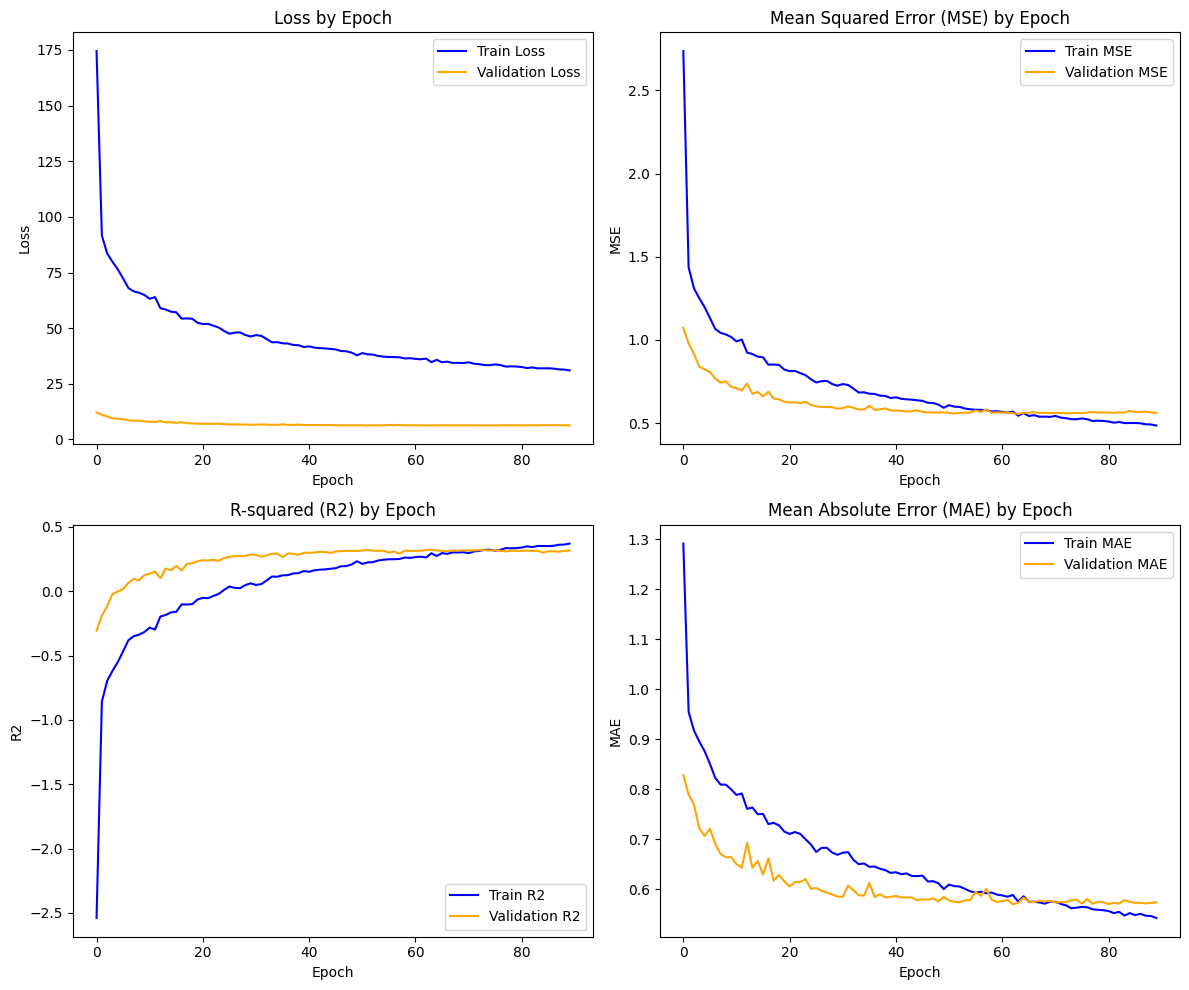

In [187]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 10))

# MSE
ax2.plot(train_mse_by_epoch, label="Train MSE", color='blue')
ax2.plot(valid_mse_by_epoch, label="Validation MSE", color='orange')
ax2.set_title("Mean Squared Error (MSE) by Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MSE")
ax2.legend()

# MAE
ax4.plot(train_mae_by_epoch, label="Train MAE", color='blue')
ax4.plot(valid_mae_by_epoch, label="Validation MAE", color='orange')
ax4.set_title("Mean Absolute Error (MAE) by Epoch")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("MAE")
ax4.legend()

# R2
ax3.plot(train_r2_by_epoch, label="Train R2", color='blue')
ax3.plot(valid_r2_by_epoch, label="Validation R2", color='orange')
ax3.set_title("R-squared (R2) by Epoch")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("R2")
ax3.legend()

# Loss
ax1.plot(train_loss_by_epoch, label="Train Loss", color='blue')
ax1.plot(valid_loss_by_epoch, label="Validation Loss", color='orange')
ax1.set_title("Loss by Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

plt.tight_layout()
plt.show()


In [188]:
i = configs["epochs"]-1

print(f"Métricas para el epoch {i}")
print("----------------")
print("----------------")
print("Train MSE: ",train_mse_by_epoch[i])
print("Valid MSE: ",valid_mse_by_epoch[i])
print("----------------")
print("Train RMSE: ",np.sqrt(train_mse_by_epoch[i]))
print("Valid RMSE: ",np.sqrt(valid_mse_by_epoch[i]))
print("----------------")
print("Train MAE: ",train_mae_by_epoch[i])
print("Valid MAE: ",valid_mae_by_epoch[i])
print("----------------")
print("Train R2: ",train_r2_by_epoch[i])
print("Valid R2: ",valid_r2_by_epoch[i])

Métricas para el epoch 89
----------------
----------------
Train MSE:  0.48615834
Valid MSE:  0.56176496
----------------
Train RMSE:  0.69725055
Valid RMSE:  0.7495098
----------------
Train MAE:  0.54244816
Valid MAE:  0.57366514
----------------
Train R2:  0.370973118111641
Valid R2:  0.3170030709759706


- Se puede observar en las curvas y en las métricas que el modelo no llega a adquirir el comportamiento de overfitting. Esto se logró probando distintos hiperparámetros y modificando el número de epocas. También ayudó variar las dimensiones de los embeddings y agregar capas de dropout posteriores a cada función de activación.

- No se observa gran diferencia entre las curvas y métricas de validación y entrenamiento (para las últimas épocas) por lo que se puede plantear que el modelo está performando de manera similar en ambos conjunto de datos, es decir, está generalizando.

# 4. Predicción
Construir una funcion capaz de recibir un usuario al azar, una cantidad "p" de películas que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con los puntajes reales contra los que el usuario asignó a dicha/s película/s.

Se va a trabajar con el dataset de validación para que el modelo no prediga datos con los que entrenó

In [189]:
def predictions(user_id, p, dataset, model, device):
    """
    Verifica las predicciones del modelo para un usuario específico y compara con los puntajes reales.

    Args:
    - user_id (int): Indice del embedding de usuario a verificar.
    - p (int): Cantidad de películas a considerar.
    - dataset (Dataset): Dataset que contiene los datos.
    - model (torch.nn.Module): Modelo entrenado.
    - device (torch.device): Dispositivo en el que se encuentra el modelo.

    Returns:
    - None: Imprime las predicciones y los puntajes reales.
    """
    # Filtrar las películas puntuadas por el usuario
    user_indices = np.where(dataset.user_idx == user_id)[0]

    # Seleccionar p películas aleatorias
    if len(user_indices) < p:
        raise ValueError(f"El usuario {user_id} tiene menos de {p} películas puntuadas.")

    sampled_indices = np.random.choice(user_indices, p, replace=False)

    # dataset para estas películas
    x_batch = [dataset.x[i] for i in sampled_indices]
    user_batch = [dataset.user_idx[i] for i in sampled_indices]
    movie_batch = [dataset.movie_idx[i] for i in sampled_indices]
    y_batch = [dataset.y[i] for i in sampled_indices]

    # to tensor y mover al dispositivo
    x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)
    user_batch = torch.tensor(user_batch, dtype=torch.int64).to(device)
    movie_batch = torch.tensor(movie_batch, dtype=torch.int64).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.float32).reshape(-1, 1).to(device)

    # Predicciones
    model.eval()  # Cambiar a modo de evaluación
    with torch.no_grad():
        y_pred = model(x_batch, user_batch, movie_batch)

    # Mover los resultados a CPU y convertir a numpy arrays
    y_pred = y_pred.cpu().numpy()
    y_batch = y_batch.cpu().numpy()


    for i in range(p):
        print(f"Película {i+1}:")
        print(f"  Puntaje real: {y_batch[i][0]:.2f}")
        print(f"  Predicción: {y_pred[i][0]:.2f}")
        print(f" movie_idx: {movie_batch[i].item()}")
        print()

    return None

In [190]:
p = 5
random_user_idx = np.random.choice(valid_ds_embeddings.user_idx)
#random_user_id = np.random.choice(df_filtered['userId'].unique())
idx_to_user_id = {v: k for k, v in user_id_to_idx.items()}
random_user_id = idx_to_user_id[random_user_idx]

print("Usuario: ",random_user_id, " | user_idx:",random_user_idx)
print("----------")
predictions(random_user_idx, p, valid_ds_embeddings, nnnetWithEmbeddings, device)

Usuario:  480  | user_idx: 47
----------
Película 1:
  Puntaje real: 4.50
  Predicción: 4.17
 movie_idx: 125

Película 2:
  Puntaje real: 4.00
  Predicción: 3.76
 movie_idx: 89

Película 3:
  Puntaje real: 4.00
  Predicción: 3.21
 movie_idx: 79

Película 4:
  Puntaje real: 3.00
  Predicción: 3.72
 movie_idx: 105

Película 5:
  Puntaje real: 3.00
  Predicción: 3.37
 movie_idx: 41



# 5. Recomendación

Contruir una funcion capaz de realizar una recomendación de película para un usuario determinado utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

### Recomendación utilizando el embedding de películas

Esta metodología se basa en encontrar películas similares en el espacio de embeddings y recomendar las que sean más parecidas a las películas que el usuario ya ha calificado positivamente.
Para ello se va a utilizar la matríz de embeddings creada y actualizada con la red neuronal. Esto nos devuelve los vectores de embeddings (que se mueven en un espacio de sies dimensiones). Y lo que se va a buscar es aplicar una función que permita encontrar vectores similares a los vectores que responden a las películas calificadas positivamente.

La función elegida se llama "Cosine Similarity", la cual calcula el ángulo entre dos vectores y se obtuvo del siguiente artículo: https://medium.com/@chenycy/build-recommendation-systems-openais-embeddings-matrix-factorization-and-deep-learning-0cac62008f0c

In [191]:
from sklearn.metrics.pairwise import cosine_similarity

In [192]:
# Diccionario de ratings
user_movie_ratings = df_filtered[df_filtered['userId'] == random_user_id].set_index('movieId')['rating'].to_dict()

In [193]:
# matriz de embeddings de peliculas
movie_embeddings = nnnetWithEmbeddings.embeddings_movies.weight.data.cpu()

In [194]:
def movie_recomendations(user_movie_ratings, movie_embeddings, movie_id_to_idx, k=5):
    """
    Recomienda películas no calificadas por el usuario, basado en embeddings de películas.

    Args:
    - user_movie_ratings: Diccionario donde las claves son los IDs de las películas y los valores son las calificaciones dadas por el usuario.
    - movie_embeddings: Matriz de embeddings de películas.
    - movie_id_to_idx: Diccionario donde las claves son los IDs de las películas y son los indices de la metriz de embeddings de películas.
    - k: Número de recomendaciones a realizar.

    Returns:
    - Lista de IDs de películas recomendadas.
    """
    # Obtener los embeddings de las películas que el usuario ha calificado positivamente
    peliculas_positivas = [movie_id for movie_id, rating in user_movie_ratings.items() if rating >= 4.0]
    peliculas_positivas_idx = [movie_id_to_idx[movie_id] for movie_id in peliculas_positivas]
    embeddings_positivos = movie_embeddings[peliculas_positivas_idx]

    # Calcular la similitud entre los embeddings de películas positivas y todos los embeddings de películas
    similitudes = cosine_similarity(embeddings_positivos, movie_embeddings)

    # Promediar las similitudes para obtener una puntuación para cada película
    similitudes_promedio = np.mean(similitudes, axis=0)

    # Ordenar las películas por similitud en orden descendente
    peliculas_ordenadas = np.argsort(similitudes_promedio)[::-1]

    # Filtrar películas ya calificadas
    peliculas_recomendadas = [pelicula for pelicula in peliculas_ordenadas if pelicula not in user_movie_ratings]

    return peliculas_recomendadas[:k]

In [196]:
recomendations = movie_recomendations(user_movie_ratings = user_movie_ratings, movie_embeddings = movie_embeddings, movie_id_to_idx=movie_id_to_idx, k=4)
print(f"El usuario {random_user_id} recibio las siguiente recomendaciones: {recomendations}")

El usuario 480 recibio las siguiente recomendaciones: [90, 78, 81, 131]


### Verificación

- Hacemos predecir la red neuronal para estas predicciones. La regresión sobre los ratings debería alcanzar valores cercanos a 4.0 para cada película.
Para ello debemos armar un nuevo DatasetWithEmbeddings para este las **recomendations**.

- Hay que hacer un pequeño ajuste para evitar errores con la función de predict. Se fijan los valores del embedding de user_idx y se debe ignorar el print de y_batch

In [203]:
new_ds = valid_ds_embeddings[valid_ds_embeddings.user_idx == random_user_idx]

In [219]:
# Nuevo dataset para predecir las recomendaciones
new_ds = valid_ds_embeddings[valid_ds_embeddings.user_idx == random_user_idx]

x = new_ds[0][0:len(recomendations)]
user_idx =  np.array([random_user_idx] * len(recomendations))
movie_idx = np.array(recomendations)
y = np.array([0] * len(recomendations)) #valores inventados

new_ds = MyDatasetWithEmbddings(x, user_idx, movie_idx, y)

In [220]:
print("Usuario: ",random_user_id)
print("----------")
predictions(random_user_idx, len(new_ds.movie_idx), new_ds, nnnetWithEmbeddings, device)

Usuario:  480
----------
Película 1:
  Puntaje real: 0.00
  Predicción: 3.83
 movie_idx: 131

Película 2:
  Puntaje real: 0.00
  Predicción: 4.08
 movie_idx: 90

Película 3:
  Puntaje real: 0.00
  Predicción: 3.90
 movie_idx: 81

Película 4:
  Puntaje real: 0.00
  Predicción: 3.86
 movie_idx: 78



- Se observan valores de predicción altos (cercanos a 4.0) para las predicciones que recibió el usuario random.

# 6. Tunning

Con el mejor modelo obtenido del punto 2, elegir al menos 3 hiperparametros y aplicar algun metodo de tuneo. Explicar resultados obtenidos.

- Random search mediante np.random.choice

In [222]:
# Definir los valores posibles para cada hiperparámetro
lr_values = np.linspace(0.0001,0.02,15)
weight_decay_values = np.linspace(0.0005,0.01,15)
epochs_values = [85] # [50, 69, 85, 100]
emb_dim_us_values = [4, 5] # [4, 5, 6, 8]
emb_dim_mov_values = [4, 5] # [4, 5, 6, 8]

# Generar combinaciones aleatorias de hiperparámetros
np.random.seed(12)
random_lr = np.random.choice(lr_values, size=5) #size=10
random_weight_decay = np.random.choice(weight_decay_values, size=5)
random_epochs = np.random.choice(epochs_values, size=5)
random_emb_dim_us = np.random.choice(emb_dim_us_values, size=5)
random_emb_dim_mov = np.random.choice(emb_dim_mov_values, size=5)

# Lista para almacenar los resultados
results = []

for lr, weight_decay, epochs, emb_dim_us, emb_dim_mov in zip(random_lr, random_weight_decay, random_epochs, random_emb_dim_us, random_emb_dim_mov):

    configs['lr'] = lr
    configs['weight_decay'] = weight_decay
    epoch_count = epochs
    configs['emb_dim_us'] = emb_dim_us
    configs['emb_dim_mov'] = emb_dim_mov

    # Inicializar el modelo, el optimizador y la función de pérdida
    nnnetWithEmbeddings = NNetWithEmbeddings(configs["emb_dim_us"], configs["emb_dim_mov"]).to(device)
    loss_function = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=configs["lr"], weight_decay=configs["weight_decay"])

    valid_mse_by_epoch = []

    for epoch in range(epoch_count):
        # Entrenamiento
        nnnetWithEmbeddings.train(True)
        epoch_loss = 0
        epoch_y_hat = []
        epoch_y = []

        for i, data in enumerate(train_dataloader_emb):
            x_batch, embed_user_batch, embed_movie_batch, y_batch = data
            x_batch, embed_user_batch, embed_movie_batch, y_batch = x_batch.to(device).float(), embed_user_batch.to(device).int(), embed_movie_batch.to(device).int(), y_batch.to(device).float().reshape(-1, 1)

            optimizer.zero_grad()
            nnet_output = nnnetWithEmbeddings(x_batch, embed_user_batch, embed_movie_batch)
            loss = loss_function(nnet_output, y_batch)
            loss.backward()
            optimizer.step()

            epoch_y += list(y_batch.detach().cpu().numpy())
            epoch_y_hat += list(nnet_output.detach().cpu().numpy())
            epoch_loss += loss.item()

        valid_epoch_loss = 0
        valid_epoch_y_hat = []
        valid_epoch_y = []

        nnnetWithEmbeddings.train(False)

        for i, data in enumerate(valid_dataloader_emb):
            x_batch, embed_user_batch, embed_movie_batch, y_batch = data
            x_batch, embed_user_batch, embed_movie_batch, y_batch = x_batch.to(device).float(), embed_user_batch.to(device).int(), embed_movie_batch.to(device).int(), y_batch.to(device).float().reshape(-1, 1)

            nnet_output = nnnetWithEmbeddings(x_batch, embed_user_batch, embed_movie_batch)
            loss = loss_function(nnet_output, y_batch)

            valid_epoch_y += list(y_batch.detach().cpu().numpy())
            valid_epoch_y_hat += list(nnet_output.detach().cpu().numpy())
            valid_epoch_loss += loss.item()

        valid_epoch_loss /= len(valid_dataloader_emb)
        valid_mse = metrics.mean_squared_error(valid_epoch_y, valid_epoch_y_hat)
        valid_mse_by_epoch.append(valid_mse)

    avg_valid_mse = sum(valid_mse_by_epoch) / len(valid_mse_by_epoch)
    last_valid_mse = valid_mse_by_epoch[-1]

    results.append({'lr': lr, 'weight_decay': weight_decay, 'epochs': epochs, 'last_valid_mse': last_valid_mse, 'avg_valid_mse': avg_valid_mse, 'emb_dim_us': emb_dim_us, 'emb_dim_mov': emb_dim_mov})
    print(f"{len(results)} - Parámetros: lr={lr}, weight_decay={weight_decay}, epochs={epochs}, emb_dim_us={emb_dim_us}, emb_dim_mov={emb_dim_mov}. Last_MSE: {last_valid_mse}, Avg_MSE: {avg_valid_mse}")

# Resultados
best_result = min(results, key=lambda x: x['last_valid_mse'])
print(f"Mejores parámetros: lr={best_result['lr']}, weight_decay={best_result['weight_decay']}, epochs={best_result['epochs']}, emb_dim_us={best_result['emb_dim_us']}, emb_dim_mov={best_result['emb_dim_mov']} con MSE promedio de validación: {best_result['avg_valid_mse']:.3f} y con  MSE={best_result['last_valid_mse']:.3f} en la última época")


1 - Parámetros: lr=0.015735714285714287, weight_decay=0.0018571428571428571, epochs=85, emb_dim_us=4, emb_dim_mov=5. Last_MSE: 0.6259653568267822, Avg_MSE: 0.6127640289418838
2 - Parámetros: lr=0.015735714285714287, weight_decay=0.0025357142857142857, epochs=85, emb_dim_us=5, emb_dim_mov=4. Last_MSE: 0.624031662940979, Avg_MSE: 0.6185210795963512
3 - Parámetros: lr=0.008628571428571428, weight_decay=0.0025357142857142857, epochs=85, emb_dim_us=4, emb_dim_mov=5. Last_MSE: 0.6176291108131409, Avg_MSE: 0.6118192448335535
4 - Parámetros: lr=0.01857857142857143, weight_decay=0.008642857142857143, epochs=85, emb_dim_us=5, emb_dim_mov=4. Last_MSE: 0.6200925707817078, Avg_MSE: 0.6160925858161028
5 - Parámetros: lr=0.0015214285714285716, weight_decay=0.0005, epochs=85, emb_dim_us=5, emb_dim_mov=4. Last_MSE: 0.5665549635887146, Avg_MSE: 0.6150061705533196
Mejores parámetros: lr=0.0015214285714285716, weight_decay=0.0005, epochs=85, emb_dim_us=5, emb_dim_mov=4 con MSE promedio de validación: 0.61

- Los resultados de la búsqueda de hiperparámetros permiten identificar que la performance mejora con las siguiente condiciones:
  - Tasa de aprendizaje bajo, entre 0.001 y 0.01.
  - Decaimiento de los pesos bajo, incluso menor al tasa de aprendizaje.
    - Se observa que el mejor parámetro fue 0.0005, el cual es el límite inferior del vector de opciones. Se puede seguir iterando con valores menores para mejorar la performance.
  - Embeddings de dimensiones acotadas. Con dimensiones muy altas empeora la performance.
  - Epochs acotados para no forzar un overfit.